In [1]:
import numpy as np
import ResonatorOptimizer as ro

In [14]:
def port(freq,Ck):
    Zport = 1 / (1j*2*np.pi*freq*Ck)
    return [np.matrix(((1,Zport[i]),(0,1)),dtype=complex) for i in range(len(freq))]

def transmission(gamma,length,Z0):
    t11 = np.cosh(gamma*length)
    t12 = Z0 * np.sinh(gamma*length)
    t21 = (1/Z0) * np.sinh(gamma*length)
    t22 = np.cosh(gamma*length)
    return [np.matrix(([t11[i],t12[i]],[t21[i],t22[i]]),dtype=complex) for i in range(len(gamma))]

def abcd(inport,transmission,outport):
    print(inport)
    return inport * transmission * outport

def s21(abcd,Rload=50,format='db'):
    A = abcd.flat[0]
    B = abcd.flat[0]
    C = abcd.flat[0]
    D = abcd.flat[0]
    
    s21 = 2 / (A + (B/Rload) + C*Rload + D)
    
    if format == 'db':
        return 20*np.log10(s21)
    elif format == 'mag':
        return s21
    else:
        raise ValueError('The format specified is not recognized. Please choose either \'db\' or \'mag\'')

In [15]:
def Qint(alpha,length):
    return np.pi / (alpha * 2 * length)

def insertion_loss(qint,qext,format='db'):
    g = qint/qext
    if format == 'db':
        return -20*np.log10(g/(g+1))
    elif format == 'mag':
        return g/(g+1)
    else:
        raise ValueError('The format specified is not recognized. Please choose either \'db\' or \'mag\'')

In [16]:
import lmfit
from lmfit.models import BreitWignerModel,LinearModel

def fit_FanoResonance(freq,trace, plot = True):
    #print (len(trace))
    start,stop = None, None #np.argmax(trace)-500,np.argmax(trace)+500# 27900,28200  #Specifies the window within the data to analyse. Set to None,None if you want the whole window
    Lin_mod = LinearModel()                                         #Linear lmfit model for background offset and slope
    BW_mod = BreitWignerModel()                                     #Breit-Wigner-Fano model
    mod = BW_mod+Lin_mod
    x = freq[start:stop]/1E6                                        #Convert frequencies to MHz
    trace = (10**(trace/10))                                        #Convert decibel data to linear
    y = trace[start:stop]
    pars = BW_mod.guess(y, x=x)                                     #Initialize fit params
    pars += Lin_mod.guess(y,x=x, slope = 0, vary = False)           
    pars['center'].set(value=x[np.argmax(y)], vary=True, expr='')   #Use numpy to find the highest transmission value. Corresponding frequency is used as a guess for the centre frequency
    pars['sigma'].set(value=0.05, vary=True, expr='')               #Linewidth
    pars['q'].set(value=0, vary=True, expr='')                      #Fano factor (asymmetry term). q=0 gives a Lorentzian
    pars['amplitude'].set(value=-0.03, vary=True, expr='')          #Amplitude
    
    out  = mod.fit(y,pars,x=x)
    print (out.fit_report())
    #print (out.params['amplitude'],out.params['q'],out.params['sigma'])
    sigma = out.params['sigma']
    centre = out.params['center']
    
    if plot == True:
        print(out.params['amplitude'],out.params['q'],out.params['sigma'])
        plt.plot(x,y, color = 'orange', label = 'Data')
        plt.plot(x, out.best_fit, color = 'darkslateblue',label = 'Fano resonance fit')
        
    return(sigma.value,centre.value,centre.value/sigma.value)       #Returns linewidth in GHz, centre in GHz and Q factor

In [17]:
# Global Parameters
__er = 11.9
__fo = 7.3e09
__h = 500e-06
__t = 50e-09
__pen_depth = 39e-09
__total_width = 100e-06
__length = 8102.64e-06
__width = 20e-06
__gap = .5*(__total_width-__width)
__Ck = 1e-15

__keyind = lambda X,X_array: min(enumerate(X_array), key=lambda x: abs(x[1]-X))

In [18]:
# Define a cpw 
cpw = ro.cpwCalcs(__width,__gap,__length,__fo, __er, h=__h, t=__t, pen_depth=__pen_depth)
# freq = np.arange(6.85,6.90,0.0001)*1e09
freq = np.linspace(6.8,6.9,500)*1e09

In [19]:
alpha_c = cpw.alpha()
beta_c = cpw.beta(freq)
gamma_c = cpw.gamma(freq)

In [20]:
inport = port(freq,__Ck)
tr = transmission(gamma_c,__length,cpw.impedance_kinetic())
outport = port(freq,__Ck)
abcd_mat = [abcd(inport[i],tr[i],outport[i]) for i in range(len(freq))]
s21_mat = [s21(abcd_mat[i],Rload=50,format='db') for i in range(len(freq))]
s21_data = np.array([float(s21_mat[i]) for i in range(len(s21_mat))])
Qint(alpha_c,__length)

[[1.    +0.j         0.-23405.13868998j]
 [0.    +0.j         1.    +0.j        ]]
[[1.    +0.j         0.-23404.44894435j]
 [0.    +0.j         1.    +0.j        ]]
[[1.    +0.j         0.-23403.75923936j]
 [0.    +0.j         1.    +0.j        ]]
[[1.    +0.j         0.-23403.06957503j]
 [0.    +0.j         1.    +0.j        ]]
[[1.    +0.j         0.-23402.37995134j]
 [0.    +0.j         1.    +0.j        ]]
[[1.    +0.j         0.-23401.69036829j]
 [0.    +0.j         1.    +0.j        ]]
[[1.    +0.j         0.-23401.00082588j]
 [0.    +0.j         1.    +0.j        ]]
[[1.    +0.j        0.-23400.3113241j]
 [0.    +0.j        1.    +0.j       ]]
[[1.    +0.j         0.-23399.62186295j]
 [0.    +0.j         1.    +0.j        ]]
[[1.    +0.j         0.-23398.93244243j]
 [0.    +0.j         1.    +0.j        ]]
[[1.    +0.j         0.-23398.24306253j]
 [0.    +0.j         1.    +0.j        ]]
[[1.    +0.j         0.-23397.55372326j]
 [0.    +0.j         1.    +0.j        ]]
[[1.    

/Users/garethjones/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


1300288.7346594501

/Users/garethjones/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


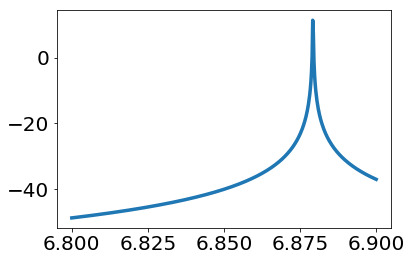

In [12]:
from matplotlib import pyplot as plt
plt.plot(freq*1e-09,s21_mat)
# plt.plot(freq*1e-09,s21_mat)
plt.show()

[[Model]]
    (Model(breit_wigner) + Model(linear))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14004
    # data points      = 500
    # variables        = 6
    chi-square         = 4.0865e-06
    reduced chi-square = 8.2724e-09
    Akaike info crit   = -9299.20908
    Bayesian info crit = -9273.92144
[[Variables]]
    q:          120344.581 (init = 0)
    sigma:      0.00825056 (init = 0.05)
    center:     6879.23614 (init = 6879.158)
    amplitude:  3.3787e-07 (init = -0.03)
    height:     4893.24881 == 'amplitude*q**2'
    fwhm:       0.00825056 == '2*(sqrt(q**2*sigma**2*(q**2+2))/max(1.e-15, 2*(q**2)-2))'
    intercept:  0.00284493 (init = -11.01017)
    slope:     -4.1556e-07 (init = 0)

<Parameter 'amplitude', 3.3786578955500825e-07, bounds=[-inf:inf]> <Parameter 'q', 120344.58115799997, bounds=[-inf:inf]> <Parameter 'sigma', 0.008250561046099891, bounds=[0.0:inf]>


0.008250561046099891

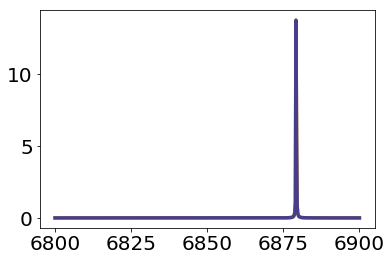

In [1061]:
fit = fit_FanoResonance(freq, s21_data, plot=True)
fit

In [1062]:
qint = Qint(alpha_c,__length)

In [1063]:
qext = 1/((1/fit[2]) - (1/qint))
insertion_loss(qint,qext)

8.903788500151968